# Step 1: Install libraries

In [67]:
!pip install pymongo
!pip install 
!pip install WordCloud

# Step 2: Import libraries

In [68]:
import json
import pymongo
from textblob import TextBlob
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import words
import nltk

# Download stopwords corpus
nltk.download('stopwords')
nltk.download('words')


# Download tokenizer
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Step 3: Load Data

In [77]:
client = pymongo.MongoClient('mongodb://localhost:27017')
db = client["AA"]
collection = db["db_airbnb"]
dataset = list(collection.find())
first_data = ""

if len(dataset) > 0:
    first_data = dataset[0]
    print(first_data)
else:
    print("No data found in the dataset.")

{'_id': '10009999', 'listing_url': 'https://www.airbnb.com/rooms/10009999', 'name': 'Horto flat with small garden', 'summary': 'One bedroom + sofa-bed in quiet and bucolic neighbourhood right next to the Botanical Garden. Small garden, outside shower, well equipped kitchen and bathroom with shower and tub. Easy for transport with many restaurants and basic facilities in the area.', 'space': 'Lovely one bedroom + sofa-bed in the living room, perfect for two but fits up to four comfortably.  There´s a small outside garden with a shower There´s a well equipped open kitchen with both 110V / 220V wall plugs and one bathroom with shower, tub and even a sauna machine! All newly refurbished!', 'description': 'One bedroom + sofa-bed in quiet and bucolic neighbourhood right next to the Botanical Garden. Small garden, outside shower, well equipped kitchen and bathroom with shower and tub. Easy for transport with many restaurants and basic facilities in the area. Lovely one bedroom + sofa-bed in t

# Step 4: Data Preprocessing

In [70]:
processed_descriptions = []

for data in dataset:
    description = data['description']
    
    # Convert text to lowercase
    description = description.lower()
    
    # Remove special characters, punctuation, and numbers
    description = re.sub(r'[^a-zA-Z\s]', '', description)
    
    # Tokenization
    tokens = word_tokenize(description)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]
    
    # Join tokens back to form text
    processed_description = ' '.join(tokens)
    processed_descriptions.append(processed_description)

# Print the first data's description before and after processing
first_data = dataset[0]
print("Before: ", first_data['description'])
print("After: ", processed_descriptions[0])


Before:  One bedroom + sofa-bed in quiet and bucolic neighbourhood right next to the Botanical Garden. Small garden, outside shower, well equipped kitchen and bathroom with shower and tub. Easy for transport with many restaurants and basic facilities in the area. Lovely one bedroom + sofa-bed in the living room, perfect for two but fits up to four comfortably.  There´s a small outside garden with a shower There´s a well equipped open kitchen with both 110V / 220V wall plugs and one bathroom with shower, tub and even a sauna machine! All newly refurbished! I´ll be happy to help you with any doubts, tips or any other information needed during your stay. This charming ground floor flat is located in Horto, a quiet and bucolic neighborhood just next to the Botanical Garden, where most of the descendants of it´s first gardeners still live. You´ll be 30 minutes walk from waterfalls in the rainforest with easy hiking trails! There are nice bars and restaurants as well as basic facilities - ph

# Step 5: Sentiment Analysis

In [72]:
sentiments = []
sentiment_labels = []

for description in processed_descriptions:
    blob = TextBlob(description)
    sentiment = blob.sentiment.polarity
    sentiments.append(sentiment)

for sentiment in sentiments:
    if sentiment > 0:
        sentiment_labels.append("Positive")
    elif sentiment < 0:
        sentiment_labels.append("Negative")
    else:
        sentiment_labels.append("Neutral")

data = {"description": processed_descriptions, "Sentiment": sentiment_labels}
df = pd.DataFrame(data)

df.tail()

,description,Sentiment
5550,relax hawaiian style gated community oceanfron...,Positive
5551,unique loft apartment frida kahlo decoration p...,Positive
5552,renovated fully equipped within walking distan...,Positive
5553,excellent private suite bathroom apart hotel r...,Positive
5554,clean fully furnish minutes walking distance t...,Positive


# Step 6: Analyze the sentiment score

In [73]:
# Analyze the sentiment scores
positive_count = sum(sentiment > 0 for sentiment in sentiments)
negative_count = sum(sentiment < 0 for sentiment in sentiments)
neutral_count = len(sentiments) - positive_count - negative_count

# Print the sentiment analysis results
print("Positive Feedback Count:", positive_count)
print("Negative Feedback Count:", negative_count)
print("Neutral Feedback Count:", neutral_count)

Positive Feedback Count: 4544
Negative Feedback Count: 181
Neutral Feedback Count: 830


# Step 7: Visualization

## Sentiment Distribution

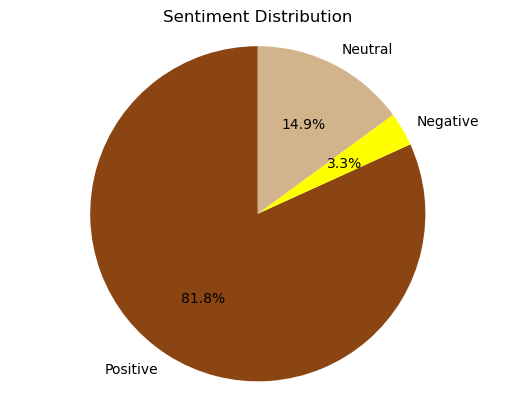

In [74]:
labels = ['Positive', 'Negative', 'Neutral']
counts = [positive_count, negative_count, neutral_count]

colors = ['#8B4513', '#FFFF00', '#d2b48c']


plt.pie(counts, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()

## Word Cloud

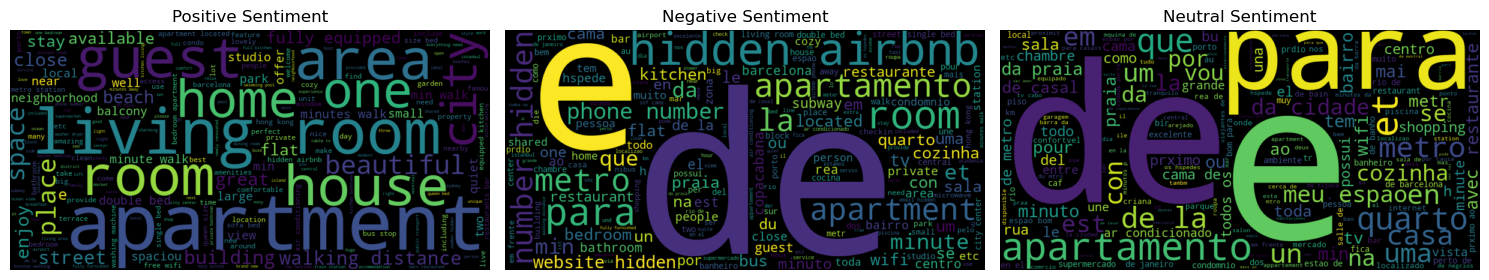

In [75]:
positive_descriptions = [description for description, sentiment in zip(processed_descriptions, sentiments) if sentiment > 0]
negative_descriptions = [description for description, sentiment in zip(processed_descriptions, sentiments) if sentiment < 0]
neutral_descriptions = [description for description, sentiment in zip(processed_descriptions, sentiments) if sentiment == 0]

positive_combined_description = ' '.join(positive_descriptions)
negative_combined_description = ' '.join(negative_descriptions)
neutral_combined_description = ' '.join(neutral_descriptions)

positive_wordcloud = WordCloud(width=800, height=400).generate(positive_combined_description)
negative_wordcloud = WordCloud(width=800, height=400).generate(negative_combined_description)
neutral_wordcloud = WordCloud(width=800, height=400).generate(neutral_combined_description)

# Plot the word clouds
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Sentiment')
axes[0].axis('off')

axes[1].imshow(negative_wordcloud, interpolation='bilinear')
axes[1].set_title('Negative Sentiment')
axes[1].axis('off')

axes[2].imshow(neutral_wordcloud, interpolation='bilinear')
axes[2].set_title('Neutral Sentiment')
axes[2].axis('off')

plt.tight_layout()
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_11792\2320685474.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(top_positive_words, rotation=45)
C:\Users\user\AppData\Local\Temp\ipykernel_11792\2320685474.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(top_negative_words, rotation=45)
C:\Users\user\AppData\Local\Temp\ipykernel_11792\2320685474.py:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[2].set_xticklabels(top_neutral_words, rotation=45)


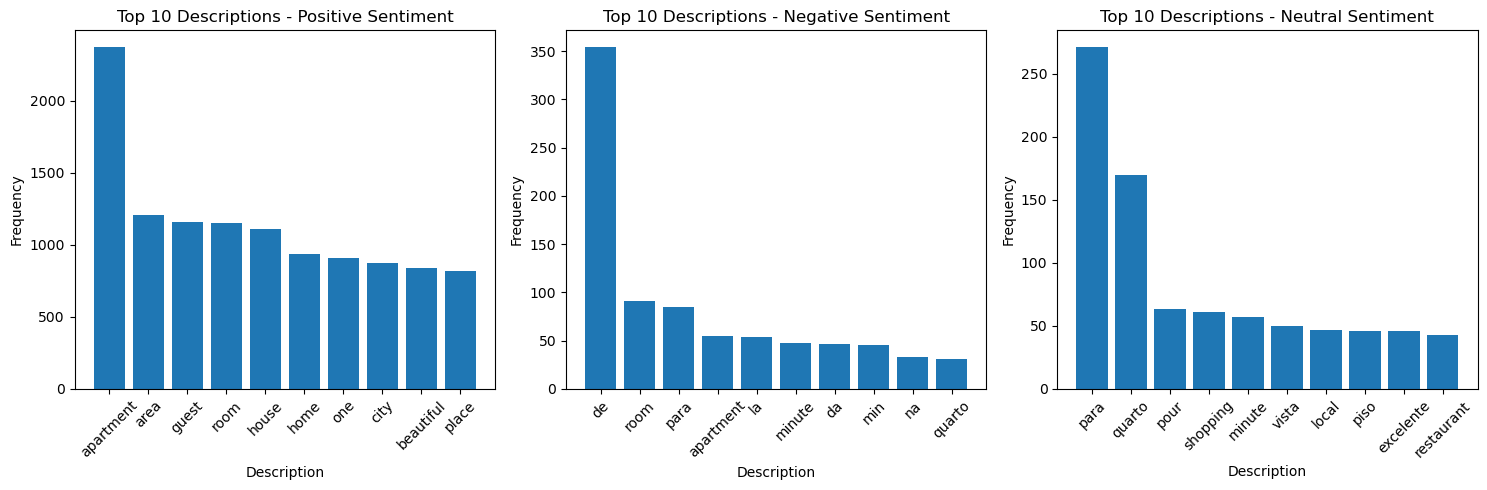

In [78]:
positive_word_freq = positive_wordcloud.process_text(positive_combined_description)
negative_word_freq = negative_wordcloud.process_text(negative_combined_description)
neutral_word_freq = neutral_wordcloud.process_text(neutral_combined_description)

english_words = set(words.words())

def filter_valid_words(word_freq, min_length=1):
    valid_word_freq = {}
    for word, freq in word_freq.items():
        if word in english_words and len(word) > min_length:
            valid_word_freq[word] = freq
    return valid_word_freq

positive_valid_word_freq = filter_valid_words(positive_word_freq)
negative_valid_word_freq = filter_valid_words(negative_word_freq)
neutral_valid_word_freq = filter_valid_words(neutral_word_freq, min_length=3)

positive_sorted_word_freq = dict(sorted(positive_valid_word_freq.items(), key=lambda x: x[1], reverse=True))
negative_sorted_word_freq = dict(sorted(negative_valid_word_freq.items(), key=lambda x: x[1], reverse=True))
neutral_sorted_word_freq = dict(sorted(neutral_valid_word_freq.items(), key=lambda x: x[1], reverse=True))

top_positive_words = list(positive_sorted_word_freq.keys())[:10]
top_positive_freq = list(positive_sorted_word_freq.values())[:10]

top_negative_words = list(negative_sorted_word_freq.keys())[:10]
top_negative_freq = list(negative_sorted_word_freq.values())[:10]

top_neutral_words = list(neutral_sorted_word_freq.keys())[:10]
top_neutral_freq = list(neutral_sorted_word_freq.values())[:10]

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Positive Sentiment
axes[0].bar(top_positive_words, top_positive_freq)
axes[0].set_title('Top 10 Descriptions - Positive Sentiment')
axes[0].set_xlabel('Description')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(top_positive_words, rotation=45)

# Negative Sentiment
axes[1].bar(top_negative_words, top_negative_freq)
axes[1].set_title('Top 10 Descriptions - Negative Sentiment')
axes[1].set_xlabel('Description')
axes[1].set_ylabel('Frequency')
axes[1].set_xticklabels(top_negative_words, rotation=45)

# Neutral Sentiment
axes[2].bar(top_neutral_words, top_neutral_freq)
axes[2].set_title('Top 10 Descriptions - Neutral Sentiment')
axes[2].set_xlabel('Description')
axes[2].set_ylabel('Frequency')
axes[2].set_xticklabels(top_neutral_words, rotation=45)

plt.tight_layout()
plt.show()